## Final Task:
This is your final evaluation for the project. As decided, we will be predicting images of people into three classes: `without_mask`, `mask_weared_incorrect` and `with_mask`. 

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers

### Loading the dataset
Make a copy of the dataset given to you in your Google Drive (keep it outside, don't put it in any folder to avoid inconvenience). Ensure it is named as `Mask_Dataset` or change the path (the variable `data_dir`) accordingly.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib

path='/content/drive/MyDrive/Mask_Dataset/'
data_dir = pathlib.Path(path)

### Know the Dataset
Most of the code is written for you as you aren't used to these libraries. You are to go through the documentation for your benefit.

In [ ]:
# Print image count
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8982


In [ ]:
# Print Output Labels
import os
output_classes = os.listdir(data_dir)
print(output_classes)

['mask_weared_incorrect', 'without_mask', 'with_mask']


[2994, 2994, 2994]


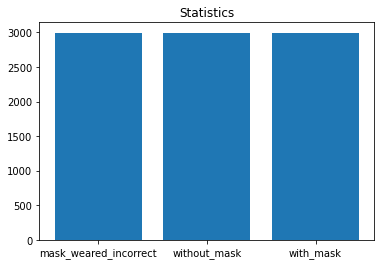

In [ ]:
# Plot count of each ouput label
import matplotlib.pyplot as plt

count=[]
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  count.append(len(im_count))

print(count)

plt.bar(output_classes,count)
plt.title("Statistics")
plt.show()

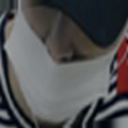

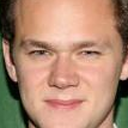

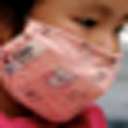

In [ ]:
# Check some sample images (Use of cv2)
import cv2
from google.colab.patches import cv2_imshow
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  sample=str(os.listdir(dir)[0])
  this_path=this_path + "/" + sample
  dir=pathlib.Path(this_path)
  img = cv2.imread(this_path)
  cv2_imshow(img)

  
  

# Your code

In [ ]:
# Check shape of the images in your dataset. This will be helpful while specifying input_shape in your Transfer Learning Model
shape=img.shape

In [ ]:
# Check if all the images have same shape, else you need to resize them to some common size
# The code provided as it is above in the template will help 
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  for i in range(0,len(im_count)):
    sample=str(os.listdir(dir)[i])
    this_path_=this_path + "/" + sample
    #dir_=pathlib.Path(this_path)
    img = cv2.imread(this_path_)
    if(img.shape!=shape):
      print(sample+" has a different shape.")
  

In [ ]:
# If the shape is variable, reshape to a common size 
# If it is same, prove it
len(im_count)

2994

In [ ]:
# Anything else you want to plot/experiment
size=np.insert(shape,0,3*len(im_count))
data=np.zeros(size)
labels=[]
j=0
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  for i in range(0,len(im_count)):
    sample=str(os.listdir(dir)[i])
    this_path_=this_path + "/" + sample
    #dir_=pathlib.Path(this_path)
    img = cv2.imread(this_path_)
    data[j]=img
    labels.append(label)
    j=j+1



### Model Definition
Choose a model for Transfer Learning (You may also experment with multiple models and keep all of them in this notebook)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [ ]:
# Choose and define base model
base_model = tf.keras.applications.MobileNetV2(input_shape=shape,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Print base model summary and have a look at the layers
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
# As we're using Transfer Learning, you do not need to train all the layers. Freeze all of the layers or train some layers (experiment)
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
# Append Fully connected/custom Conv2D/Dropout/MaxPooling layers to the base model
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.AveragePooling2D(pool_size=(7,7), padding="same"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))

In [ ]:
# Add the final output layer
model.add(tf.keras.layers.Dense(3,activation="softmax"))

In [ ]:
# Print your model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3

In [ ]:
# Compile you model (set the parameters like loss/optimizers/metrics)
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

### Data Augmentation and Pre-processing
Augment the data. You may also try dyanamic augmentation using [`tf.keras.preprocessing.image.ImageDataGenerator `](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).   
You may use [`tf.keras.applications.vgg16.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)(or some other base model's utility) for pre-processing (can also be passed as a parameter to `ImageDataGenerator`)

In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input # Change according to your base model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# Your code 

In [ ]:
data=preprocess_input(data)

### Training and Validation Dataset  
Split the dataset into training and validation (We'll be looking for your validation accuracy, assume we are using complete dataset for now). 

Hint: `flow_from_directory` used with `ImageDataGenerator` will simplify things for you.

In [ ]:
# Your code
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels_ = lb.fit_transform(labels)
#labels_ = to_categorical(labels_, num_classes=3)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels_,test_size=0.20, stratify=labels_, random_state=42)

In [ ]:
del(base_model)

### Training  
Train your model for some epochs and plot the graph. Try and save your best model. Experiment with the parameters of `model.fit`

In [ ]:
from keras.callbacks import ModelCheckpoint

history=model.fit(aug.flow(trainX, trainY, batch_size=32), steps_per_epoch= len(trainX) // 32, validation_data=(testX, testY), validation_steps=len(testX) // 32,
	epochs=20)
# ModelCheckpoint is helpful to save the model giving best results (brownie points)

Epoch 1/20
224/224 [==============================] - 44s 137ms/step - loss: 0.3011 - accuracy: 0.8875 - val_loss: 0.1047 - val_accuracy: 0.9616
Epoch 2/20
224/224 [==============================] - 26s 116ms/step - loss: 0.1798 - accuracy: 0.9374
Epoch 3/20
224/224 [==============================] - 26s 116ms/step - loss: 0.1483 - accuracy: 0.9449
Epoch 4/20
224/224 [==============================] - 26s 116ms/step - loss: 0.1350 - accuracy: 0.9509
Epoch 5/20
224/224 [==============================] - 26s 116ms/step - loss: 0.1162 - accuracy: 0.9583
Epoch 6/20
224/224 [==============================] - 27s 123ms/step - loss: 0.1109 - accuracy: 0.9582
Epoch 7/20
224/224 [==============================] - 26s 116ms/step - loss: 0.1032 - accuracy: 0.9644
Epoch 8/20
224/224 [==============================] - 26s 115ms/step - loss: 0.1048 - accuracy: 0.9620
Epoch 9/20
224/224 [==============================] - 26s 116ms/step - loss: 0.0962 - accuracy: 0.9645
Epoch 10/20
224/224 [==========

### Evaluate the performance

In [ ]:
# Plot training & validation loss/accuracy values
test_loss, test_acc = model.evaluate(testX,testY)

57/57 [==============================] - 2s 28ms/step - loss: 0.0462 - accuracy: 0.9844


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
preds=model.predict(testX)
#classification_report(np.argmax(preds,axis=1),testY)

In [ ]:
#x=np.argmax(preds,axis=1)
#preds[:,x]=1
preds


array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [ ]:
# Use the classification report to print precision, recall, f1-score for the three classes(optional, brownie points)